# 3 | _Prophet_ Modeling: Ridership, All Ridership
---
* [01 API Data Requests](01_API_pulls.ipynb)
* [01.1 Additional BART Data](01_v2_bart.ipynb.ipynb)
* [02 Initial EDA](02_EDA.ipynb)
* _[03 First Model: Prophet](03_prophet.ipynb)_
---

This notebook documents `1` model: using Facebook's `Prophet` to forecast ridership. 

* `Jan 2000` - `Apr 2022` monthly data is used. 

The model does NOT perform well. Data from ridership decline toward end of `2018` and abrupt change in `March 2022` due to COVID provide a negative trend, so the forecasts are VERY BAD. 
    * Prophet is designed to _detect_ changes, but only does so on the very first `80%` of the data, which does not include the years of interest. Manual changepoints can be visualized and implemented. 

In [36]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [37]:
# CUSTOMS 
plt.style.use('gstyle.mplstyle')

import warnings
warnings.filterwarnings('ignore')

#### Function below: ensures appropriate date time `type` AND `index`, and `ds` for `Prophet` to use.

In [38]:
def date_index(df): 
    df['date'] = pd.to_datetime(df['ds'])
    df = df.set_index('date')

    return(df)

## Ridership with Prophet

In [39]:
# importing bart data
file = '../data/processed/bart.csv'
bart_df = pd.read_csv(file)
bart_df = date_index(bart_df)

In [40]:
# importing fuel data
file = '../data/processed/fuel_m.csv'
fuel_df = pd.read_csv(file)
fuel_df = date_index(fuel_df)

In [134]:
# merging data 
merged = bart_df.merge(fuel_df['fuel_m'], right_on = 'date', left_on = 'date')
# merged['ds'] = pd.to_datetime(merged['ds'])
merged.rename(columns = { 'ridership' : 'y'}, inplace = True)
merged = merged['2010-01-01':'2020-01-01']

train_df = merged[: '2019-12-01']
test_df = merged['2020-01-01':]
train_df.head()

,ds,y,fuel_m
date,,,
2010-01-01,2010-1-01,1329472,3.065
2010-02-01,2010-2-01,1318752,2.993
2010-03-01,2010-3-01,1414724,3.104
2010-04-01,2010-4-01,1433632,3.138
2010-05-01,2010-5-01,1381416,3.136


In [135]:
m = Prophet()       # instantiate Prophet model

# # with additional regressor:
# pro_regressor.add_regressor('fuel_m')

# fit data 
m.fit(merged)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.4966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       356.364    0.00123927       117.911      0.6873      0.6873      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        356.85    0.00194781       156.202   2.045e-05       0.001      171  LS failed, Hessian reset 
     197       357.415   3.66372e-09       68.5354     0.02488           1      300   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [136]:
# make future df 
future_data = m.make_future_dataframe( periods = 365) 

# forecast on test data
forecast = m.predict(test_df)
# forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,1.614407e+06,1.532761e+06,1.667447e+06,1.614407e+06,1.614407e+06,-16252.703452,-16252.703452,-16252.703452,-16252.703452,-16252.703452,-16252.703452,0.0,0.0,0.0,1.598154e+06


In [137]:
# fore2 = forecast
# fore2['y'] = test_df['y']

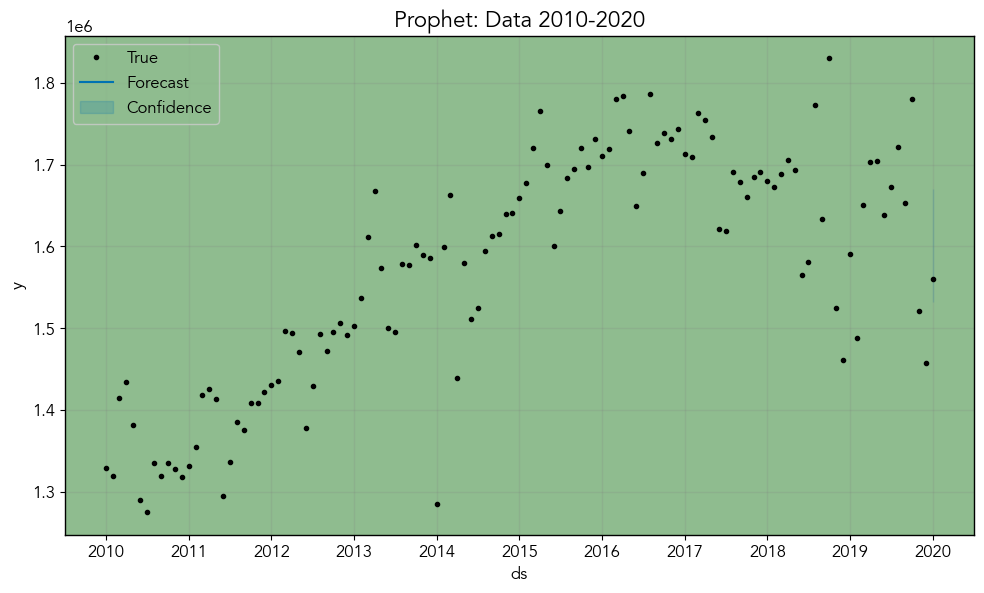

In [154]:
m.plot(forecast);
plt.title(label = 'Prophet: Data 2010-2020', fontsize=16)
plt.legend(['True', 'Forecast', 'Confidence']); 

In [139]:
m = Prophet()       # instantiate Prophet model

# # with additional regressor:
# pro_regressor.add_regressor('fuel_m')

# fit data 
m.fit(merged)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.4966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       356.364    0.00123927       117.911      0.6873      0.6873      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        356.85    0.00194781       156.202   2.045e-05       0.001      171  LS failed, Hessian reset 
     197       357.415   3.66372e-09       68.5354     0.02488           1      300   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


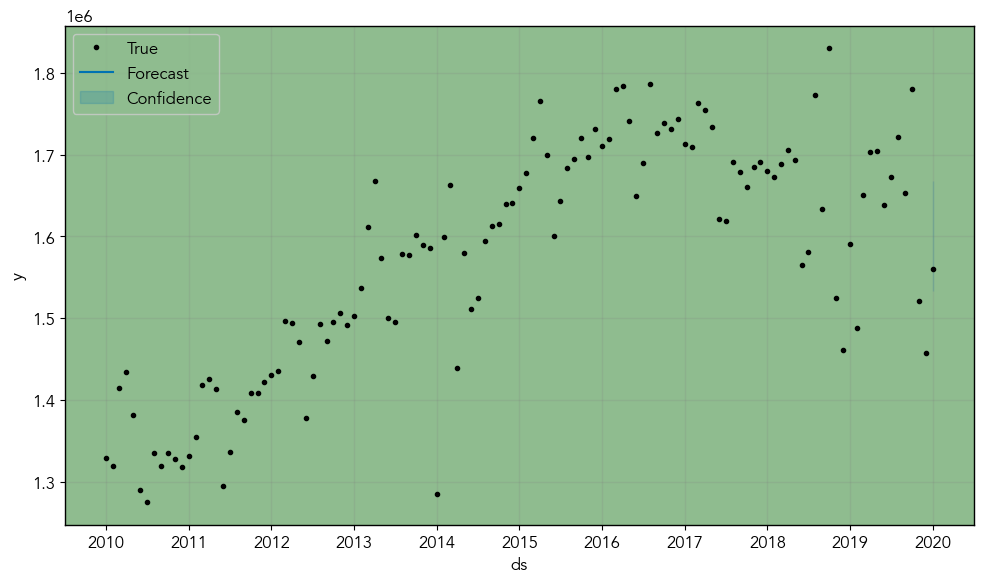

In [140]:
m.plot(forecast);
plt.legend(['True', 'Forecast', 'Confidence', 'Test']);

In [141]:
# make future df 
future_data = m.make_future_dataframe( periods = 365) 

# forecast on test data
forecast = m.predict(test_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-01,1.598154e+06,1.531046e+06,1.668859e+06


> #### Visualizing changepoints to implement: 

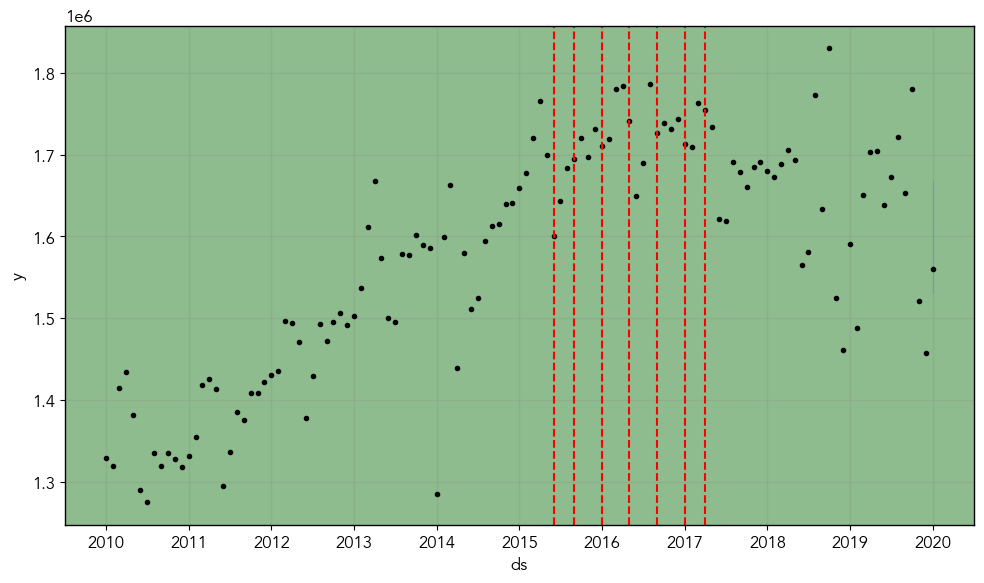

In [142]:
# Python
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


In [143]:
preds = forecast.yhat
trues = test_df.y
preds.index = trues.index
preds.shape, trues.shape

((1,), (1,))

> #### Errors on first fit: 

In [144]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math

mae = mean_absolute_error(trues, preds)
mse = mean_squared_error(trues, preds)
rmse = math.sqrt(mse)
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

MAE: 38353.166990
MSE: 1470965418.186208
RMSE: 38353.166990


ID      | MODEL   | DATA      | RMSE        | MSE       | MAE       | CV        | MAPE      | MASE      | AIC 
---     | ---     | ---        | ---       | ---       | ---       | ---       | ---       | ---       | ---  
A       | PROPHET | < 2019   | 446 152   | 199 052 198 567| 375 686   |          
B       | PROPHET | All BART   | 1 243 269   | 5 457 200 928 927| 1 181 450   |          

> ## Cross Validation over subsets of series: 
> * train on `5` years 
> * spit every window for `2` years
> * forecast for `1` year

In [145]:
# Python
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model = m, 
    initial ='1825 days',   # pd.to_timedelta(30*12,unit="D") 
    period ='730 days',     # pd.to_timedelta(30*12,unit="D")
    horizon = '365 days')

### Can also use manual cut-offs 
# cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
# df_cv2 = cross_validation(pro_regressor, cutoffs=cutoffs, horizon='365 days')

INFO:prophet:Making 3 forecasts with cutoffs between 2015-01-02 00:00:00 and 2019-01-01 00:00:00
  0%|          | 0/3 [00:00<?, ?it/s]


Initial log joint probability = -70.269
Iteration  1. Log joint probability =    104.843. Improved by 175.112.
Iteration  2. Log joint probability =    141.442. Improved by 36.5995.
Iteration  3. Log joint probability =    172.088. Improved by 30.6459.
Iteration  4. Log joint probability =    185.125. Improved by 13.0364.
Iteration  5. Log joint probability =    185.453. Improved by 0.328434.
Iteration  6. Log joint probability =    185.488. Improved by 0.0350923.
Iteration  7. Log joint probability =    185.493. Improved by 0.00444737.
Iteration  8. Log joint probability =    185.512. Improved by 0.0189709.
Iteration  9. Log joint probability =    185.515. Improved by 0.00342856.
Iteration 10. Log joint probability =    185.516. Improved by 0.000978841.
Iteration 11. Log joint probability =    185.519. Improved by 0.00280533.
Iteration 12. Log joint probability =    185.524. Improved by 0.00503892.
Iteration 13. Log joint probability =    185.525. Improved by 0.00113588.
Iteration 14

 33%|███▎      | 1/3 [00:05<00:10,  5.20s/it]


Initial log joint probability = -92.3271
Iteration  1. Log joint probability =    85.0555. Improved by 177.383.
Iteration  2. Log joint probability =    228.917. Improved by 143.862.
Iteration  3. Log joint probability =    228.959. Improved by 0.0411802.
Iteration  4. Log joint probability =    229.082. Improved by 0.122949.
Iteration  5. Log joint probability =     229.17. Improved by 0.0883059.
Iteration  6. Log joint probability =    229.293. Improved by 0.123111.
Iteration  7. Log joint probability =    229.588. Improved by 0.294477.
Iteration  8. Log joint probability =     229.98. Improved by 0.392274.
Iteration  9. Log joint probability =    265.347. Improved by 35.3671.
Iteration 10. Log joint probability =     265.39. Improved by 0.0435262.
Iteration 11. Log joint probability =    267.393. Improved by 2.00291.
Iteration 12. Log joint probability =    267.546. Improved by 0.153127.
Iteration 13. Log joint probability =    268.322. Improved by 0.775111.
Iteration 14. Log joint

 67%|██████▋   | 2/3 [00:11<00:05,  5.56s/it]

Initial log joint probability = -2.33886
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       330.712    0.00448718       115.746           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       331.206   0.000281213        75.182   4.182e-06       0.001      193  LS failed, Hessian reset 
     199        331.28   0.000143288       70.1736      0.3422           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       331.452   0.000494936        104.73   5.109e-06       0.001      372  LS failed, Hessian reset 
     299       331.597   5.33891e-06       53.8477       1.246      0.2991      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       331.612   4.41164e-05       77.2678   5.481e-07       0.001      527  LS failed, Hessian rese

100%|██████████| 3/3 [00:15<00:00,  5.15s/it]


In [146]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-02-01,1.635002e+06,1.576244e+06,1.695779e+06,1677020,2015-01-02
1,2015-03-01,1.715988e+06,1.656418e+06,1.777669e+06,1720652,2015-01-02
2,2015-04-01,1.663736e+06,1.604815e+06,1.727909e+06,1765712,2015-01-02
3,2015-05-01,1.690338e+06,1.628857e+06,1.754058e+06,1699052,2015-01-02
4,2015-06-01,1.594653e+06,1.533500e+06,1.653871e+06,1600284,2015-01-02


In [147]:
forecast = m.predict(test_df)

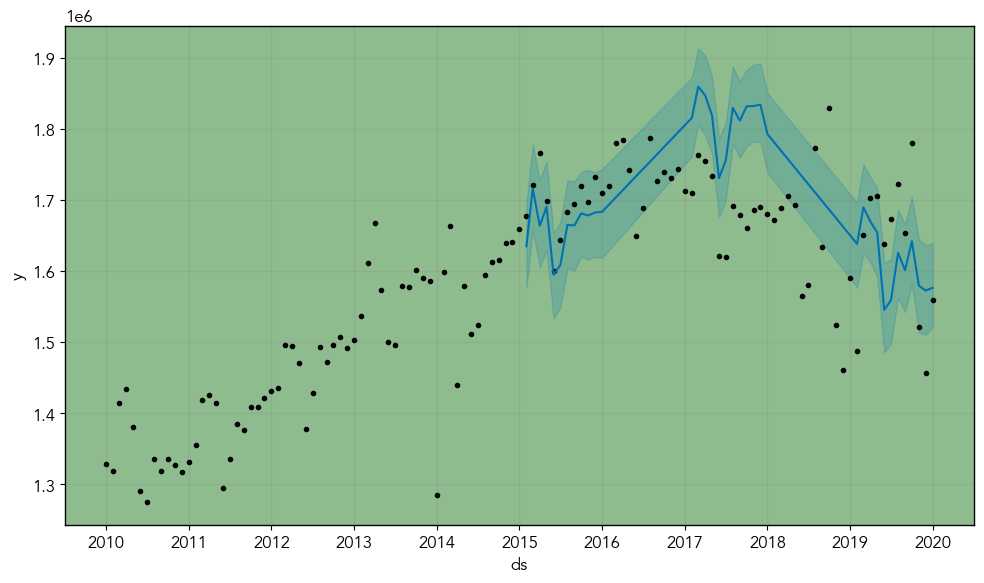

In [148]:
m.plot(df_cv);

In [149]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,1.183244e+10,108777.001605,99276.053813,0.062600,0.061647,0.060470,0.333333
1,58 days,1.125117e+10,106071.551406,86824.747036,0.055152,0.061647,0.052917,0.333333
2,59 days,3.653311e+09,60442.625651,47003.583883,0.027200,0.023945,0.026617,0.666667
3,89 days,7.112436e+09,84335.258250,79440.811879,0.045548,0.054945,0.045536,0.333333
4,90 days,6.714574e+09,81942.505532,76122.350081,0.043462,0.052929,0.043645,0.333333


In [150]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
18,304 days,8.439365e+09,91866.015407,74725.055033,0.045559,0.038295,0.044127,0.666667
19,333 days,9.124478e+09,95522.134440,84759.591511,0.051280,0.038295,0.049964,0.666667
20,334 days,1.209261e+10,109966.394171,102646.724615,0.064140,0.079309,0.062121,0.333333
21,364 days,1.152396e+10,107349.726557,95155.142534,0.059879,0.079309,0.057764,0.333333
22,365 days,4.566330e+09,67574.624594,52051.085099,0.031149,0.015624,0.030444,0.666667


ID      | MODEL   | DATA      | RMSE        | MSE       | MAE       | MAPE      | MASE      | AIC |
---     | ---     | ---        | ---       | ---       | ---       | ---       | ---       | ---       
A       | PROPHET | < 2019   | 446 152   | 199 052 198 567| 375 686   |      
B       | PROPHET | All BART, CV   |167 050   | 2 790 595 000| 1 181 450   | 0.102         

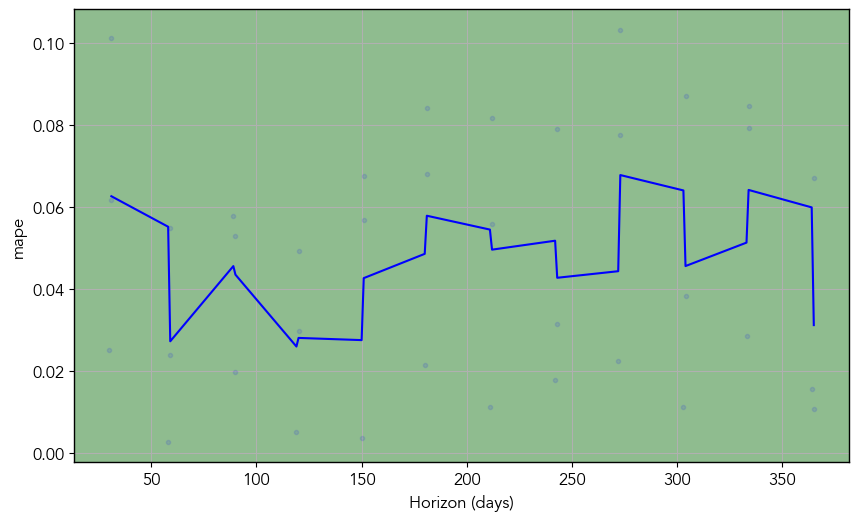

In [151]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

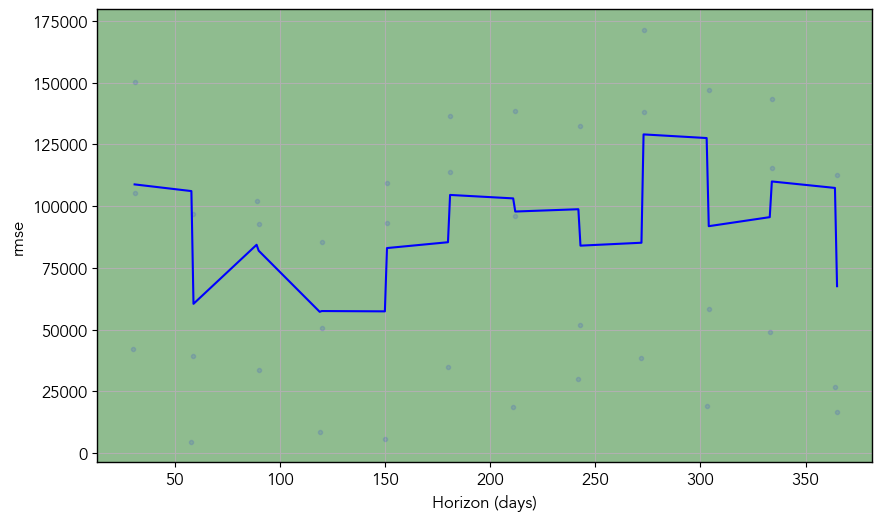

In [152]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

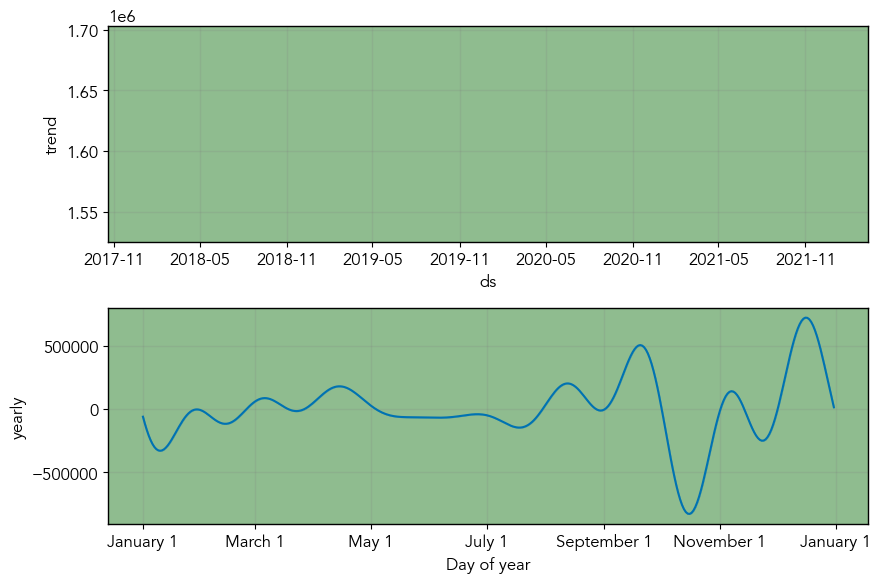

In [153]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

plot_components_plotly(m, forecast)

fig2 = m.plot_components(forecast)